# Sentiment Analysis

## Synopsis

Sentiment Analysis is a natural language processing technique used to determine whether data is positive, negative or neutral. It helps companies gauge customer sentiments on their products from customer reviews. In this project, we will be examining Amazon reviews for video games and using some machine learning models for sentiment analysis. We will also be comparing between 2 vectorizer techniques, CountVectorizer and TfidfVectorizer.

## Data

The data contains a collection of video game reviews written in the Amazon.com marketplace and associated metadata from 1995 until 2015 and can be downloaded [here](https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz). It contains the following columns:

| Variable          | Description                                                                                                    |
|-------------------|:---------------------------------------------------------------------------------------------------------------|
| marketplace       | 2 letter country code of the marketplace where the review was written.                                         |
| customer_id       | Random identifier that can be used to aggregate reviews written by a single author.                            |
| review_id         | The unique ID of the review.                                                                                   |
| product_id        | The unique Product ID the review pertains to.                                                                  |
| product_parent    | Random identifier that can be used to aggregate reviews for the same product.                                  |
| product_title     | Title of the product.                                                                                          |
| product_category  | Broad product category that can be used to group reviews (also used to group the dataset into coherent parts). |
| star_rating       | The 1-5 star rating of the review.                                                                             |
| helpful_votes     | Number of helpful votes.                                                                                       |
| total_votes       | Number of total votes the review received.                                                                     |
| vine              | Review was written as part of the Vine program.                                                                |
| verified_purchase | The review is on a verified purchase.                                                                          |
| review_headline   | The title of the review.                                                                                       |
| review_body       | The review text.                                                                                               |
| review_date       | The date the review was written.                                                                               |

## Loading in the Data

Load in the required libraries.

In [1]:
import pandas as pd
import numpy as np
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

Read in the zip file into a dataframe and check the first few rows.

In [2]:
dfAmazon = pd.read_csv('amazon_reviews_us_Video_Games_v1_00.tsv.gz', sep='\t', compression='gzip', error_bad_lines=False)

b'Skipping line 20630: expected 15 fields, saw 22\nSkipping line 28172: expected 15 fields, saw 22\nSkipping line 54791: expected 15 fields, saw 22\n'
b'Skipping line 75419: expected 15 fields, saw 22\nSkipping line 104832: expected 15 fields, saw 22\n'
b'Skipping line 138464: expected 15 fields, saw 22\nSkipping line 194849: expected 15 fields, saw 22\n'
b'Skipping line 201568: expected 15 fields, saw 22\nSkipping line 242567: expected 15 fields, saw 22\n'
b'Skipping line 493585: expected 15 fields, saw 22\nSkipping line 502478: expected 15 fields, saw 22\n'
b'Skipping line 660750: expected 15 fields, saw 22\n'


In [3]:
dfAmazon.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


In [4]:
dfAmazon.shape

(1780268, 15)

## Data Cleaning

Check for missing values.

In [5]:
dfAmazon.isnull().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline      28
review_body          59
review_date          27
dtype: int64

Remove missing values from 'review_body'.

In [6]:
dfAmazon.dropna(subset=['review_body'], inplace=True)

We will only be using the columns 'star_rating' and 'review_body' for analysis.

In [7]:
amazonReviews = dfAmazon[['star_rating', 'review_body']].copy()

In [8]:
amazonReviews.head()

,star_rating,review_body
0,5,"Used this for Elite Dangerous on my mac, an am..."
1,5,"Loved it, I didn't even realise it was a gami..."
2,1,poor quality work and not as it is advertised.
3,3,"nice, but tend to slip away from stick in inte..."
4,4,"Great amiibo, great for collecting. Quality ma..."


Add in a new column 'good_review' that converts the star rating to a binary class, where 1 represents that the review is good and 0 represents that the review is bad.

In [9]:
amazonReviews['good_review'] = amazonReviews.star_rating
amazonReviews.good_review[amazonReviews.star_rating <= 3] = 0
amazonReviews.good_review[amazonReviews.star_rating >= 4] = 1

In [10]:
amazonReviews.sample(5)

,star_rating,review_body,good_review
560028,5,It great ! Thanks !,1
410884,5,Got this as a gift for my hubby and he loves i...,1
1499338,2,I got it as a christmas gift for my boyfriend'...,0
343289,4,I would like to give some clarity on this prod...,1
628404,4,they are still raving about them; of course th...,1


Remove duplicate reviews.

In [11]:
amazonReviews = amazonReviews.drop_duplicates(subset = ['review_body'])

## Text Cleaning

Create function that makes text lowercase, removes text in square brackets, removes punctuation and removes words containing numbers.

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [13]:
amazonReviews['review_body'] = amazonReviews['review_body'].apply(lambda x: clean_text(x))

Remove stopwords from the texts.

In [14]:
stop = stopwords.words('english')

amazonReviews['review_body'] = amazonReviews['review_body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
amazonReviews['review_body'].sample(10)

1092404    basic knowledge bulletstorm one see another ge...
1099499    would mistaken oh young seeker knowledge respe...
133640     retroduo portable amazing many ways feels look...
868933     say something ive never tried grandson smiling...
1774215    completed first two tomb raider games impresse...
208092         great product came exactly described business
1230563    uncharted drakes fortune solid game doubt cont...
1293668    announced nba elite canceled coming full game ...
1596700    game enjoyable battle system requires strategy...
1657335    wonderful cdrom daughter much fun playing lear...
Name: review_body, dtype: object

Split the data into training and test sets.

In [15]:
sampled_reviews = amazonReviews.sample(n = 5000, random_state=42)
X = sampled_reviews.review_body
y = sampled_reviews.good_review

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Exploratory Data Analysis

### Distribution of Star Ratings

Text(0.5, 1.0, 'Distribution of Star Ratings')

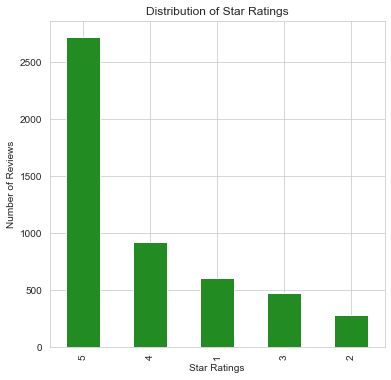

In [16]:
sampled_reviews.star_rating.value_counts(ascending = False).plot(kind= 'bar', color='forestgreen',figsize= (6,6))

plt.xlabel("Star Ratings")
plt.ylabel('Number of Reviews')
plt.title('Distribution of Star Ratings')

There appears to be many more customers who give a high number of stars (4 or 5) as compared to low number of stars.

### Distribution of Number of Words 

Text(0.5, 1.0, 'Distribution of Number of Words')

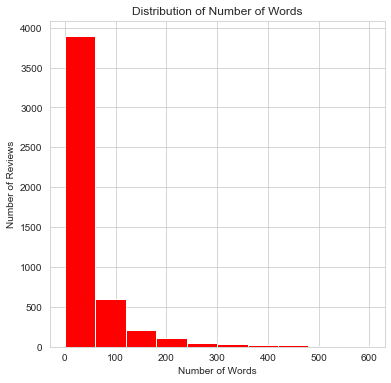

In [17]:
sampled_reviews.review_body.str.split().str.len().plot(kind='hist', color='red',figsize= (6,6), range=(0,600))


plt.xlabel("Number of Words")
plt.ylabel('Number of Reviews')
plt.title('Distribution of Number of Words')

### Distribution of Good Reviews

Text(0.5, 1.0, 'Distribution of Good Reviews')

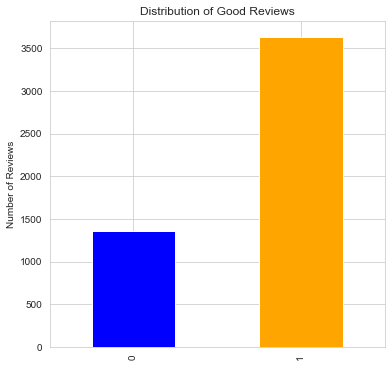

In [18]:
sampled_reviews_positive = sampled_reviews[sampled_reviews['good_review'] == 1]
sampled_reviews_negative = sampled_reviews[sampled_reviews['good_review'] == 0]

number = pd.Series([len(sampled_reviews_negative), len(sampled_reviews_positive)])
number.plot(kind='bar', color = ('blue','orange'), figsize= (6,6))

plt.ylabel('Number of Reviews')
plt.title('Distribution of Good Reviews')

### Most frequent words

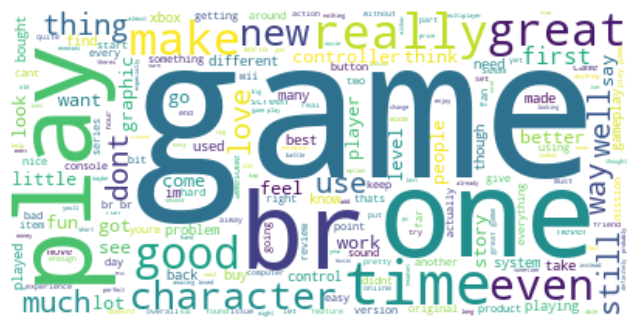

In [19]:
text_for_cloud = " ".join(x for x in sampled_reviews['review_body'])
wordcloud = WordCloud(background_color="white").generate(text_for_cloud)

plt.figure(figsize= (8,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most frequent words for positive sentiment

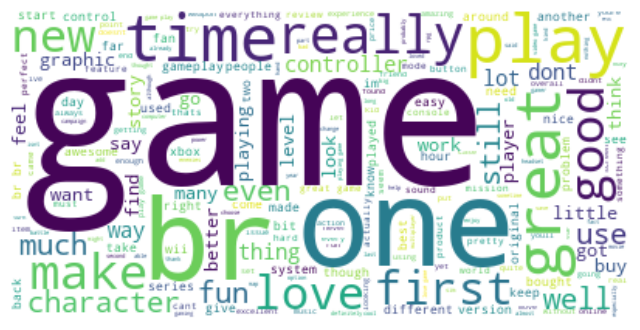

In [20]:
text_for_cloud = " ".join(x for x in sampled_reviews_positive['review_body'])
wordcloud = WordCloud(background_color="white").generate(text_for_cloud)

plt.figure(figsize= (8,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As expected, words such as 'good', 'fun' and 'love' can be found in the positive reviews.

### Most frequent words for negative sentiment

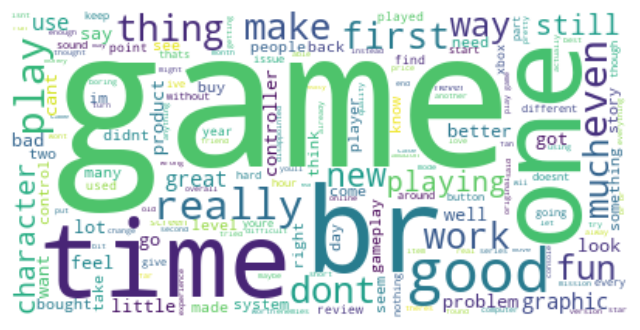

In [21]:
text_for_cloud = " ".join(x for x in sampled_reviews_negative['review_body'])
wordcloud = WordCloud(background_color="white").generate(text_for_cloud)

plt.figure(figsize= (8,8), dpi= 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As expected, words such as 'bad' and 'problem' can be found in the negative reviews. We still see some positive words such as 'good' and 'fun' but this is most likely due to the words 'not good' and 'not fun'. 

## Tokenization using CountVectorizer

The Bag-of-words model(BoW) is the simplest way of extracting features from text. BoW converts text into the matrix of occurrence of words within a document. This matrix is known as a Document-Term Matrix(DTM). In this case, we will create the DTM using CountVectorizer and only 1-gram models will be used.

In [22]:
count_vect = CountVectorizer(ngram_range = (1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test= count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

View the DTM  as a dataframe. Each row represents a review and the number indicates the number of times the word appears in the review.

In [23]:
pd.DataFrame(count_vect_train, columns = count_vect.get_feature_names()).head()

,aa,aaa,aaaaa,aaaaand,aaaaing,aaas,aaron,aas,ab,aback,...,zora,zoras,zr,zul,zumba,zur,ðÿ,المطلوبةbr,بالجودة,ليست
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Modelling (CountVectorizer)

The following models will be used to classify the text as positive or negative:
    
- Naive Bayes
- Logistic Regression
- Support Vector Machine (SVM)

### Naive Bayes

Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. It calculates the probabilities as follows:

![png](plots/bayes.png)

where y is the class variable and X refers to the features.

In [24]:
cv_naive = MultinomialNB().fit(count_vect_train, y_train)
y_pred_cv_naive = cv_naive.predict(count_vect_test)

Plot the confusion matrix and classification report.

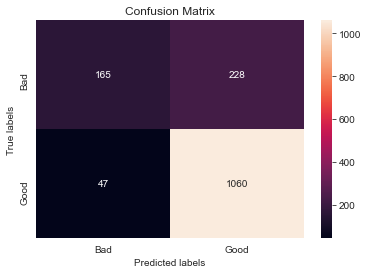

In [25]:
cm = confusion_matrix(y_test, y_pred_cv_naive)

# Create graphics for confusion matrix
labels = ['Bad','Good']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d");

# Labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

In [26]:
print(classification_report(y_test, y_pred_cv_naive))

              precision    recall  f1-score   support

           0       0.78      0.42      0.55       393
           1       0.82      0.96      0.89      1107

    accuracy                           0.82      1500
   macro avg       0.80      0.69      0.72      1500
weighted avg       0.81      0.82      0.80      1500



### Logistic Regression

Logistic regression is an extension of linear regression to binary outcomes. It
is used to model binary outcome variable y by modeling the log odds of the outcome as a linear combination of the predictor variables X.

In [27]:
cv_log = LogisticRegression(max_iter=500).fit(count_vect_train, y_train)
y_pred_cv_log = cv_log.predict(count_vect_test)

Plot the confusion matrix and classification report.

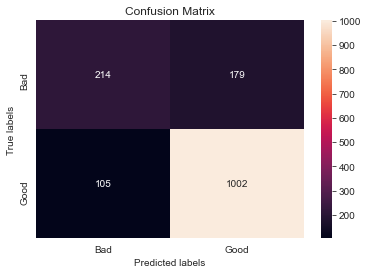

In [28]:
cm = confusion_matrix(y_test, y_pred_cv_log)

# Create graphics for confusion matrix
labels = ['Bad','Good']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d");

# Labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

In [29]:
print(classification_report(y_test, y_pred_cv_log))

              precision    recall  f1-score   support

           0       0.67      0.54      0.60       393
           1       0.85      0.91      0.88      1107

    accuracy                           0.81      1500
   macro avg       0.76      0.72      0.74      1500
weighted avg       0.80      0.81      0.80      1500



### Support Vector Machine (SVM)

Support vector machine attempts to find a hyperplane in an N-dimensional space (N - the number of features) that distinctly classifies the data points.

In [30]:
cv_svm = SVC(gamma='auto').fit(count_vect_train, y_train)
y_pred_cv_svm = cv_svm.predict(count_vect_test)

Plot the confusion matrix and classification report.

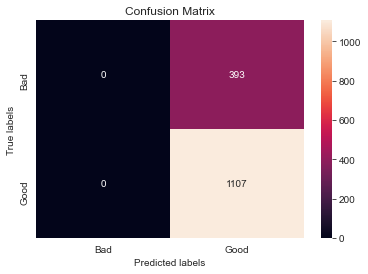

In [31]:
cm = confusion_matrix(y_test, y_pred_cv_svm)

# Create graphics for confusion matrix
labels = ['Bad','Good']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d");

# Labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

In [32]:
print(classification_report(y_test, y_pred_cv_svm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       393
           1       0.74      1.00      0.85      1107

    accuracy                           0.74      1500
   macro avg       0.37      0.50      0.42      1500
weighted avg       0.54      0.74      0.63      1500



### Summary of Results

Create a table that collates the results from the classification tables.

In [33]:
def classification_table(y_test, *args):
    df = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1-score'])
    for y_pred in args:
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        df = df.append({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}, ignore_index=True)
    return df

In [34]:
results_cv = classification_table(y_test,y_pred_cv_naive, y_pred_cv_log, y_pred_cv_svm)
results_cv.index = ['Naive Bayes CV', 'Logistic Regression CV','SVM CV']
results_cv

,Accuracy,Precision,Recall,F1-score
Naive Bayes CV,0.816667,0.822981,0.957543,0.885177
Logistic Regression CV,0.810667,0.848434,0.905149,0.875874
SVM CV,0.738000,0.738000,1.000000,0.849252


## Tokenization using TfidfVectorizer

Rather than compute the frequency of words in a text, tf-idf, which stands for term frequency — inverse document frequency, computes how relevant a term is in a document. Take note that the following calculations are used for scikit-learn's TfidfVectorizer so how tf-idf is calculated in other cases may vary. The details are as follows:

**TF (Term Frequency)** - Measures the frequency of a word in a text, calculated by taking the number of times the word occurs in the text divided by the total number of words in the text.

**IDF (Inverse Document Frequency)** - Measures how much information the word provides, i.e., if it's common or rare across all text, calculated as follows: ln(n + 1 / df + 1) + 1, where n refers to the total number of texts and df (document frequency) refers to the number of texts that contain the word. IDF diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.

**TF-IDF (Term Frequency — Inverse Document Frequency)** - Reflects how important a word is to a document, calculated by taking TF multiplied by IDF

The tf-idf vectors are then normalized by the Euclidean norm, resulting in the output produced by TfidfVectorizer.

In [35]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test= tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

In [36]:
pd.DataFrame(tfidf_vect_train, columns = tfidf_vect.get_feature_names()).head()

,aa,aaa,aaaaa,aaaaand,aaaaing,aaas,aaron,aas,ab,aback,...,zora,zoras,zr,zul,zumba,zur,ðÿ,المطلوبةbr,بالجودة,ليست
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelling (TfidfVectorizer)

Repeat the modelling process on the text tokenized using TfidfVectorizer.

### Naive Bayes

In [37]:
tv_naive = MultinomialNB().fit(tfidf_vect_train, y_train)
y_pred_tv_naive = tv_naive.predict(tfidf_vect_test)

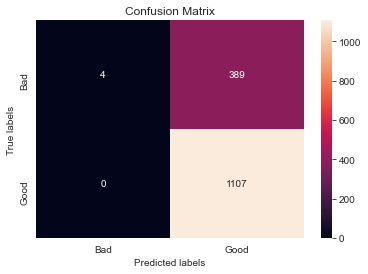

In [38]:
cm = confusion_matrix(y_test, y_pred_tv_naive)

# Create graphics for confusion matrix
labels = ['Bad','Good']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d");

# Labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

In [39]:
print(classification_report(y_test, y_pred_cv_naive))

              precision    recall  f1-score   support

           0       0.78      0.42      0.55       393
           1       0.82      0.96      0.89      1107

    accuracy                           0.82      1500
   macro avg       0.80      0.69      0.72      1500
weighted avg       0.81      0.82      0.80      1500



### Logistic Regression

In [40]:
tv_log = LogisticRegression(max_iter=500).fit(tfidf_vect_train, y_train)
y_pred_tv_log = tv_log.predict(tfidf_vect_test)

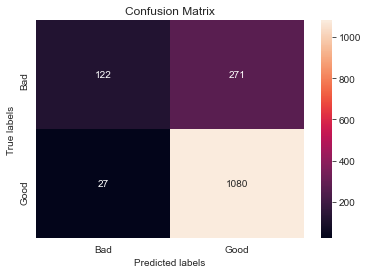

In [41]:
cm = confusion_matrix(y_test, y_pred_tv_log)

# Create graphics for confusion matrix
labels = ['Bad','Good']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d");

# Labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

In [42]:
print(classification_report(y_test, y_pred_tv_log))

              precision    recall  f1-score   support

           0       0.82      0.31      0.45       393
           1       0.80      0.98      0.88      1107

    accuracy                           0.80      1500
   macro avg       0.81      0.64      0.66      1500
weighted avg       0.80      0.80      0.77      1500



### Support Vector Machine

In [43]:
tv_svm = SVC(gamma='auto').fit(tfidf_vect_train, y_train)
y_pred_tv_svm = tv_svm.predict(tfidf_vect_test)

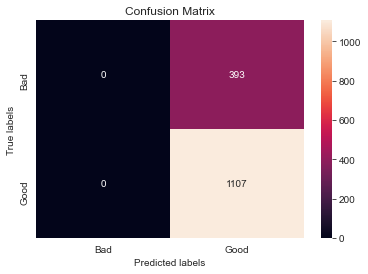

In [44]:
cm = confusion_matrix(y_test, y_pred_tv_svm)

# Create graphics for confusion matrix
labels = ['Bad','Good']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d");

# Labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

In [45]:
print(classification_report(y_test, y_pred_tv_svm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       393
           1       0.74      1.00      0.85      1107

    accuracy                           0.74      1500
   macro avg       0.37      0.50      0.42      1500
weighted avg       0.54      0.74      0.63      1500



### Summary of Results

In [46]:
results_tv = classification_table(y_test,y_pred_tv_naive, y_pred_tv_log, y_pred_tv_svm)
results_tv.index = ['Naive Bayes TV', 'Logistic Regression TV','SVM TV']
results_tv

,Accuracy,Precision,Recall,F1-score
Naive Bayes TV,0.740667,0.739973,1.00000,0.850557
Logistic Regression TV,0.801333,0.799408,0.97561,0.878763
SVM TV,0.738000,0.738000,1.00000,0.849252


## Final Results

Combine the 2 summary of results.

In [47]:
combined = pd.concat([results_cv,results_tv], axis=0)
combined

,Accuracy,Precision,Recall,F1-score
Naive Bayes CV,0.816667,0.822981,0.957543,0.885177
Logistic Regression CV,0.810667,0.848434,0.905149,0.875874
SVM CV,0.738000,0.738000,1.000000,0.849252
Naive Bayes TV,0.740667,0.739973,1.000000,0.850557
Logistic Regression TV,0.801333,0.799408,0.975610,0.878763
SVM TV,0.738000,0.738000,1.000000,0.849252


Since the data is quite unbalanced, accuracy will not be a good indicator for which is the better model since the models will be biased towards the majority class. Thus, we should compare the f1-scores.

Text(0.5, 1.0, 'F1-score by Model and Vectorizer')

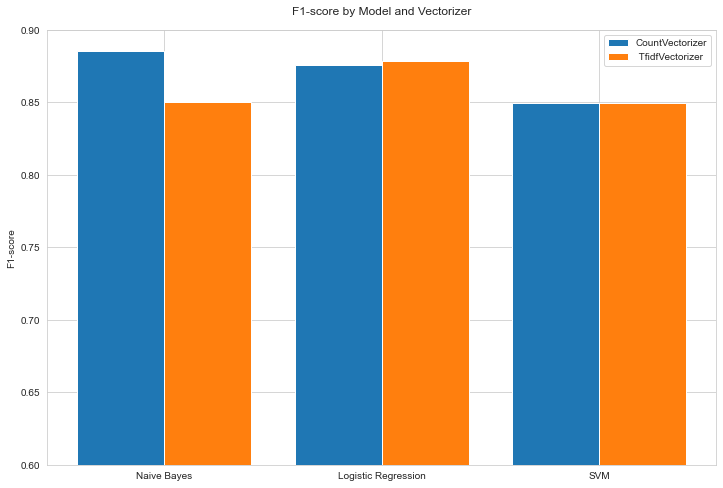

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(3)
bar_width = 0.4
b1 = ax.bar(x, combined.loc[combined.index.str.contains('CV'), 'F1-score'],
            width=bar_width, label = 'CountVectorizer')
b2 = ax.bar(x + bar_width, combined.loc[combined.index.str.contains('TV'), 'F1-score'],
            width=bar_width, label= ' TfidfVectorizer')

# Add legend and y
ax.legend()
ax.set_ylim(0.6,0.9)

# Fix x-axis labels
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(['Naive Bayes','Logistic Regression', 'SVM'])

# Add axis and chart labels.
ax.set_ylabel('F1-score')
ax.set_title('F1-score by Model and Vectorizer', pad=15)

Naive Bayes appears to perform better on the data tokenized using CountVectorizer as compared to TfidfVectorizer while there is not much difference for Logistic Regression and SVM. Overall, the models are able to classify the positive and negative reviews very well and the best model is Naive Bayes with CountVectorizer with a f1-score of 88.5%. More analysis such as making the data more balanced or performing hyperparameter tuning could improve the model results.